In [1]:
# Importing necessary packages, and classes adapted from decision boundary visualization studies

from huggingface_hub import hf_hub_download, HfApi
import os
import torch
from torchvision import datasets, transforms
from IPython.display import display
from matplotlib import pyplot as plt
import shutil

import model.Models as Models
from ssnp import visualize_decision_boundaries

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIGURATIONS FOR THE VISUALIZATION SCRIPT

SEED = 42  # For reproducibility

IMPORT_SSNP_MODEL = True   # If True, the SSNP model is imported from HuggingFace and saved locally. If false, trains from scratch.
SSNP_REPO_ID = "cmlavo/SSNP"    # HuggingFace repo ID for the SSNP model (make sure your token has access this)
SSNP_MODEL_FILENAME = "ssnp_MNIST.keras"    # Filename to load/save the SSNP model locally
SAVE_SSNP_HF = True     # If True, saves the trained SSNP model to HuggingFace (requires write access to the repo)

MODEL_SETTING = "medium" # "small" for SmallConvNet, "medium" for MediumConvNet
# The models to visualize decision boundaries for (list is complete, remove entries as desired)
#   Note: there is no "Vanilla" model for the SmallConvNet, may encounter an error if configured as such
MODELS = ["Vanilla", "Constant", "Cyclic", "Exponential", "Linear", "LinearUniformMix", "Random"]
BATCH_SIZE = 10000  # Batch size for the data classifier inference step (specify based on available memory)
EPOCHS = 300        # Number of epochs to train the SSNP model (if training from scratch)
PATIENCE = 100      # Early stopping patience
SHOW_POINTS = False # If True, highlights the MNIST points in the decision boundary visualization
NAME_SUFFIX = ""    # Optional suffix for the saved image file name

In [3]:
# Importing MNIST dataset from online
data_dir = os.path.abspath(os.path.join(os.getcwd(), "../data"))
MNIST_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(SEED)

In [4]:
# Importing the MNIST classifier model

if MODEL_SETTING == "small":
    # Use SmallConvNet for MNIST classification
    MNIST_model = Models.SmallConvNet()
    model_repo_id = "JulienStal/MNIST-SmallConvs-AdversarialSchedulers"
elif MODEL_SETTING == "medium":
    # Use ConvNet for MNIST classification
    MNIST_model = Models.MediumConvNet()
    model_repo_id = "JulienStal/MNIST-MediumConvs-AdversarialSchedulers"

device_torch = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
    )

In [5]:
# Import the SSNP pre-trained model weights from HuggingFace
local_path = os.path.abspath(os.path.join(os.getcwd(), "../models/ssnp", SSNP_MODEL_FILENAME))

if IMPORT_SSNP_MODEL:    
    cached_path = hf_hub_download(repo_id=SSNP_REPO_ID, filename=SSNP_MODEL_FILENAME)    
    shutil.copy(cached_path, local_path)
    print(f"Model saved to {local_path}")

Model saved to c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\models\ssnp\ssnp_MNIST.keras



 48/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Saving image. 300x300 - MNIST - medium_conv_Vanilla


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


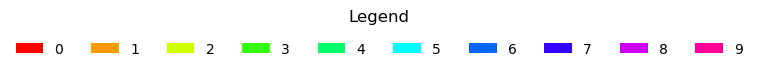

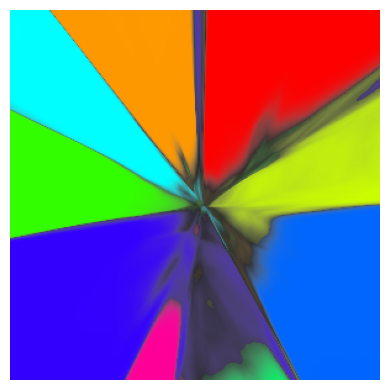

 53/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Saving image. 300x300 - MNIST - medium_conv_Constant


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


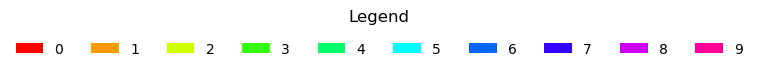

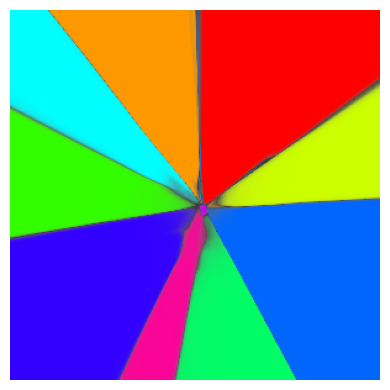

 85/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Saving image. 300x300 - MNIST - medium_conv_Cyclic


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


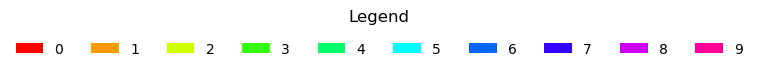

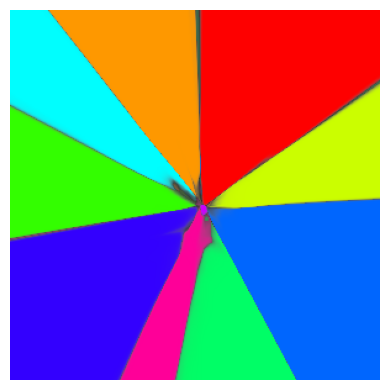

 41/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Saving image. 300x300 - MNIST - medium_conv_Exponential


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


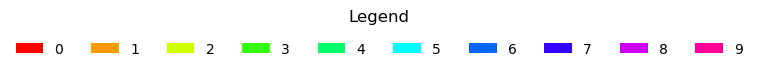

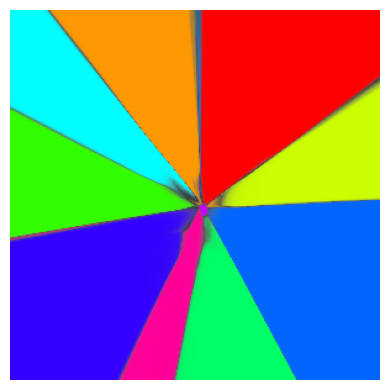

 16/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Saving image. 300x300 - MNIST - medium_conv_Linear


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


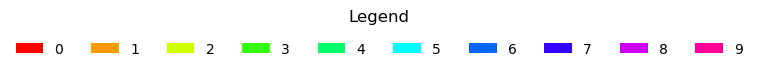

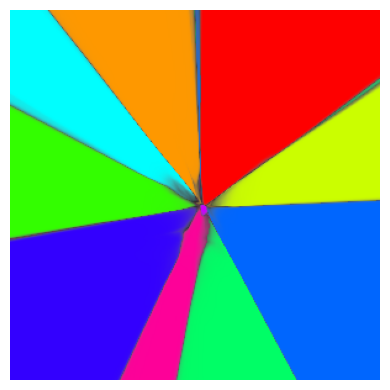

 83/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Saving image. 300x300 - MNIST - medium_conv_LinearUniformMix


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


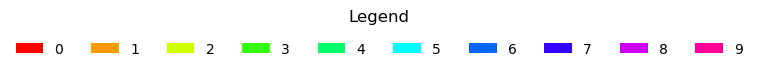

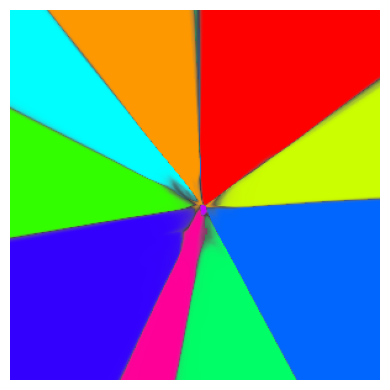

 30/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


Processing 10000 points for 2D projection...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Saving image. 300x300 - MNIST - medium_conv_Random


c:\Users\clavo\OneDrive - epfl.ch\EPFL\Cours\Semester 2\CS-439\OPTML\project_code\ssnp.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


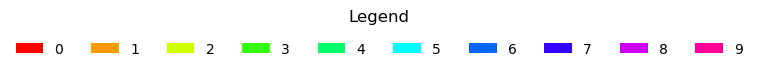

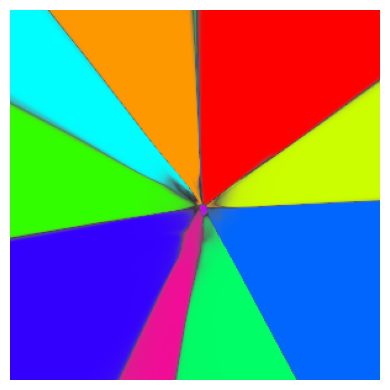

In [6]:
# Loop through all trained models to produce adversarial examples

ssnps = []
im_grids = []
prob_grids = []
dbms = []
models = []
pts_arr = []

for model in MODELS:
    # Import the model weights from HuggingFace
    model_name = f"{MODEL_SETTING}_conv_{model}"
    model_file_name = f"model_{model}.pth"    
    local_pth_path = hf_hub_download(repo_id=model_repo_id, filename=model_file_name, force_download=False)    
    MNIST_model.load_state_dict(torch.load(local_pth_path, map_location=device_torch))

    # Generate visualization
    ssnp, im_grid, prob_grid, dbm, pts = visualize_decision_boundaries(
        original_dataset = MNIST_data,
        dataset_name = "MNIST",
        classifier_model = MNIST_model,
        classifier_model_name = model_name,
        ssnp_path_and_name = local_path,
        image_name_suffix = NAME_SUFFIX,
        batch_size = BATCH_SIZE,
        ssnp_training_epochs = EPOCHS,
        ssnp_training_patience = PATIENCE,
        show_points = SHOW_POINTS,
        verbose = True,
    )

    ssnps.append(ssnp)
    im_grids.append(im_grid)
    prob_grids.append(prob_grid)
    dbms.append(dbm)
    models.append(MNIST_model)
    pts_arr.append(pts)

In [7]:
# Save the SSNP .keras model to HuggingFace

if SAVE_SSNP_HF:
    api = HfApi()
    api.upload_file(
        path_or_fileobj=local_path,
        path_in_repo="ssnp_MNIST.keras",
        repo_id=SSNP_REPO_ID,
        repo_type="model"
    )

No files have been modified since last commit. Skipping to prevent empty commit.


Reference DBM with the pixel highlighted red:


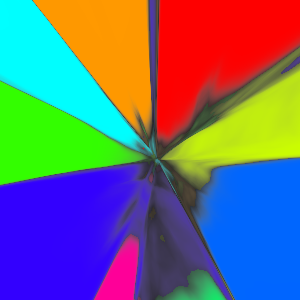

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Label of synthetic image at pixel (148, 143): 5.0 (confidence 0.37)


(-0.5, 27.5, 27.5, -0.5)

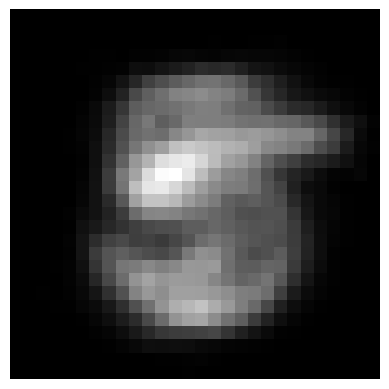

In [8]:
# Print the synthetic image for a given pixel
PIXEL_X, PIXEL_Y = (148, 143) # vertical and horizontal pixel coordinates in the decision boundary visualization grid
MODEL_TO_VISUALIZE = "Vanilla" # Name of the model in MODELS to visualize

model_index = MODELS.index(MODEL_TO_VISUALIZE)
index = PIXEL_X*300 + PIXEL_Y
ssnp = ssnps[0]
img_grid = im_grids[0]
prob_grid = prob_grids[0]
dbm = dbms[0]
model = models[0]
pts = pts_arr[0]

# Set pixel to red in the dbm and display
dbm.putpixel((PIXEL_Y, PIXEL_X), (255, 0, 0))  # Set pixel to red
print("Reference DBM with the pixel highlighted red:")
display(dbm)

# Points values of the pixel
pt = pts[index]

# Get the synthetic image for the given pixel and print it
synthetic_img = torch.tensor(ssnp.inverse_transform(torch.tensor(pt).unsqueeze(0))).view(1, 1, 28, 28)
label_tensor = torch.tensor(img_grid[PIXEL_X][PIXEL_Y]).view(1,1)

# Print the label of the synthetic image
print(f"Label of synthetic image at pixel ({PIXEL_X}, {PIXEL_Y}): {label_tensor.item()} (confidence {prob_grid[PIXEL_X][PIXEL_Y]:.2f})")

plt.imshow(synthetic_img[0].squeeze().cpu(), cmap='gray')
plt.axis('off')
